In [2]:
import os
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch
import torch.nn as nn
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [6]:
device = torch.device('cpu')
print('Using the following device') 
print(device)

Using the following device
cpu


In [192]:
batch_size = 128
latent_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [10]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [8]:
generator = nn.Sequential(
        # in: latent_size x 1 x 1

        nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        # out: 512 x 4 x 4

        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # out: 256 x 8 x 8

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # out: 128 x 16 x 16

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # out: 64 x 32 x 32

        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
        # out: 3 x 64 x 64
    )

In [11]:
generator = to_device(generator, device)
generator.load_state_dict(torch.load("G-600.pth"))
generator.eval()

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [12]:
discriminator = nn.Sequential(
        # in: 3 x 64 x 64

        nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 64 x 32 x 32

        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 128 x 16 x 16

        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 256 x 8 x 8

        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 512 x 4 x 4

        nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
        # out: 1 x 1 x 1

        nn.Flatten(),
        nn.Sigmoid()
    )

In [14]:
discriminator = to_device(discriminator, device)
discriminator.load_state_dict(torch.load("D-600.pth"))
discriminator.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

In [185]:
def show_picture(fake_images, index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        # ax.imshow(fake_images.cpu().detach())
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [190]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0001.png
Saving generated-images-0002.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0003.png
Saving generated-images-0004.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0005.png
Saving generated-images-0006.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0007.png
Saving generated-images-0008.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0009.png


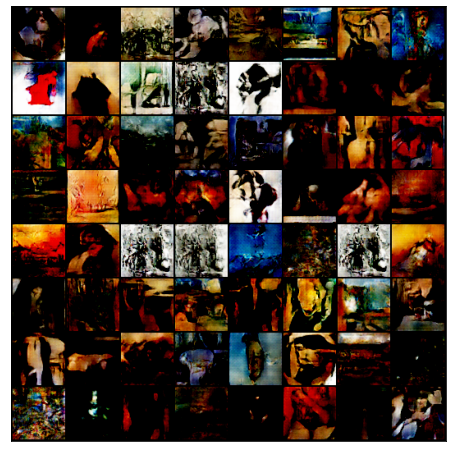

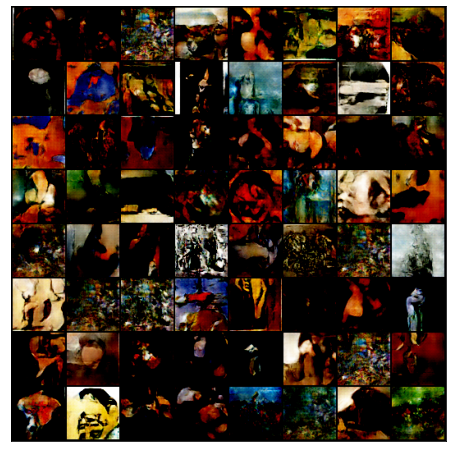

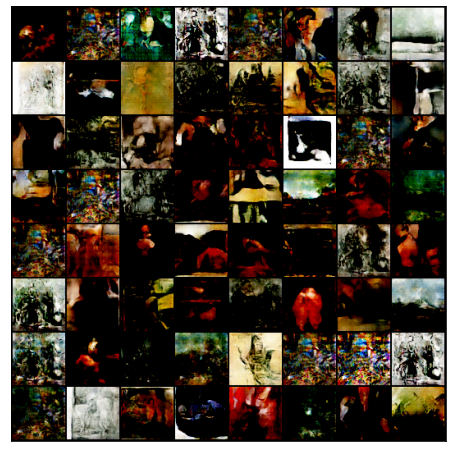

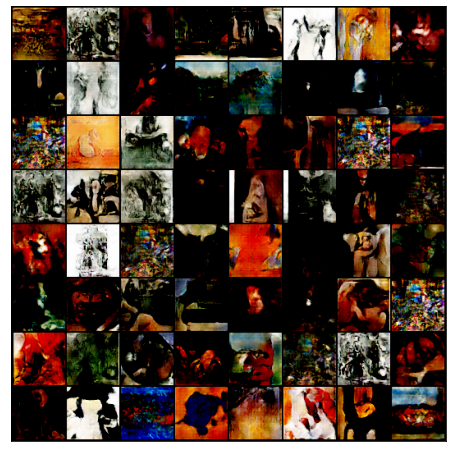

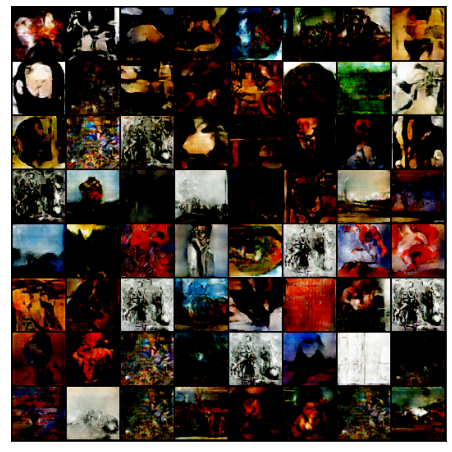

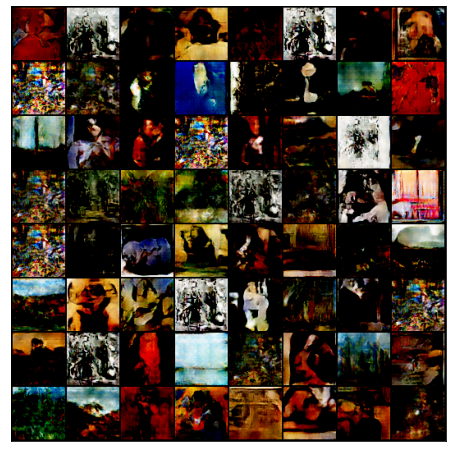

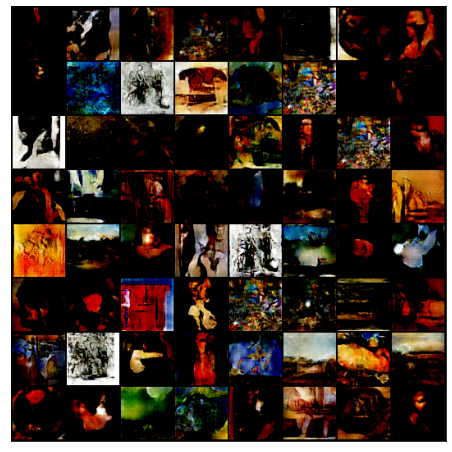

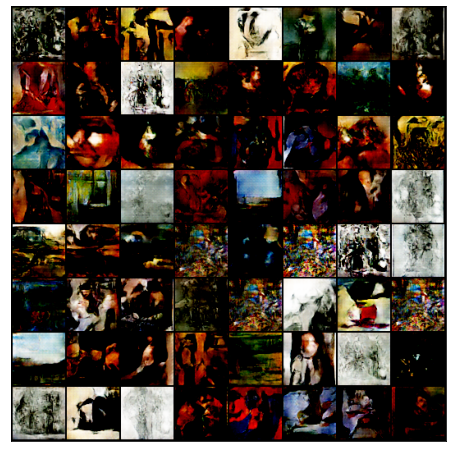

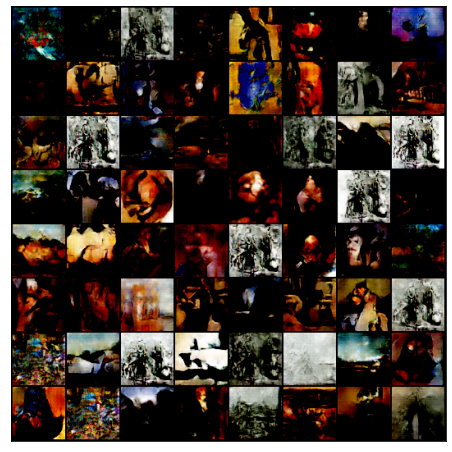

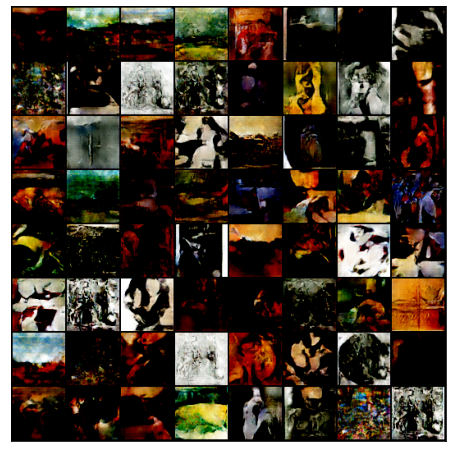

In [210]:
for i in range (0, 10):
    fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
    fake_images = generator(fixed_latent)
    show_picture(fake_images, i, fixed_latent, show=True)